# README!
<div class="alert alert-danger">
This notebook was a part of the development and exploration synthetic ripple analysis. This <b>will not run</b> due to github file limitations in uploading data! If you want to run it, ask me for the data. The code however does include synthetic dataset generation and ripple z-score exploration. Interesting notes (at least imo!) and observations that were made <i>during</i> development and exploration are included throughout. This contains a lot of my thoughts as I was going through the analysis. Feel free to ask questions if you are so inclined or continue to explore and read silently (or popcorn read)! :) 
</div>

Wavelet libraries

In [ ]:
import pywt

# What's happening here?

- Explore different synthetic ripple amplitudes and quantify real-time algorithm performance
- Latency vs sensitivity with varying simulated ripple amplitudes and thresholds

In [ ]:
#imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import scipy.signal as signal #signal processing stuff (e.g. filters, hilbert transform, etc.)
from scipy.stats import linregress
import scipy
import struct
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import svgutils.transform as sg
import sys

#nelpy!
import nelpy as nel  #recommended import for nelpy
import nelpy.plotting as npl  #recommended import for the nelpy plotting library
import nelpy.io.trodes as neltro


from IPython.display import SVG, display, Image

# I saved my online ripple detection filter taps and stuff in a file....gonna import this for all analysis
import imp
ripple_filtering = imp.load_source('ripple_filtering', '/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/DataAnalysisScripts/ripple_filtering.py')

In [ ]:
# magics!
# %matplotlib notebook 
%matplotlib inline

In [ ]:
#my plot settings!
npl.setup()
npl.set_palette(npl.colors.cows) #moo!
npl.setup(font='Universalis ADF Cd Std', font_scale=2, palette=npl.colors.cows, style='white',\
         rc=({'figure.figsize': (12, 6), 'font.size': 18, 'axes.labelsize': 25, \
             'axes.titlesize':33, 'legend.fontsize': 20, 'ytick.labelsize': 20, 'xtick.labelsize': 20,\
             'agg.path.chunksize':100000000000}))

# Load Data

In [ ]:
"""
I don't really care about the raw data but commented out below is how
to load it. I'm gonna just load up the ripple band filtered signal 
since that's how we're gonna be generating ripples
"""
# #I looked at channel 1 on tetrodes 2 and 3 so let's stick with those again...for now...
# #the data is already reference subtracted and lowpass filtered (400 Hz) from Trodes but not yet decimated (We'll decimate more creatively)
# lfp = neltro.load_wideband_lfp_rec("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/singleChan.rec","/home/shayok/Documents/Code/trodes/",\
#                              tetrode=[15,16,], channel=[1,1], \
#                              data_already_extracted=True, decimation_factor=1, )
# lfp.signals, lfp.labels
#ripple band filtered signal
rbf = nel.load_pkl("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/singleChanAnalysis/rbfilter_t15c1t16c1.pkl", zip=False)
rbf = rbf.rbfilter_t15c1t16c1
envelope = nel.load_pkl("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/singleChanAnalysis/rbpower_t15c1t16c1.pkl", zip=False)
envelope = envelope.rbpower_t15c1t16c1

In [ ]:
#When I do care about lfp load it up here!
#I'm only looking at tetrode 15 for most the analysis here so I'll just load that up...
#Once again, this is 400 Hz lpf from Trodes. 
lfp = neltro.load_wideband_lfp_rec("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/singleChan.rec","/home/shayok/Documents/Code/trodes/",\
                             tetrode=[15,], channel=[1,], \
                             data_already_extracted=True, decimation_factor=1, )
lfp.signals, lfp.labels

([<AnalogSignalArray at 0x7fc9ef3cad30: 1 signals> for a total of 1:20:02:807 hours],
 array(['t15c1'], 
       dtype='<U5'))

In [ ]:
rbf[0,0]

<AnalogSignalArray at 0x7fb96808dac8: 1 signals> for a total of 1:20:02:807 hours

(<ColorGroup at 0x7f7cff2c62e8 with 11 colors>,
 ['galloway',
  'gelbvieh',
  'shorthorn',
  'hereford',
  'texas_longhorn',
  'jersey',
  'charolais',
  'brown_swiss',
  'holstein',
  'angus',
  'texas_aggie'])

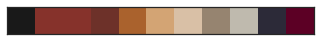

In [ ]:
#moo
npl.colors.cows,npl.colors.cows.color_names,

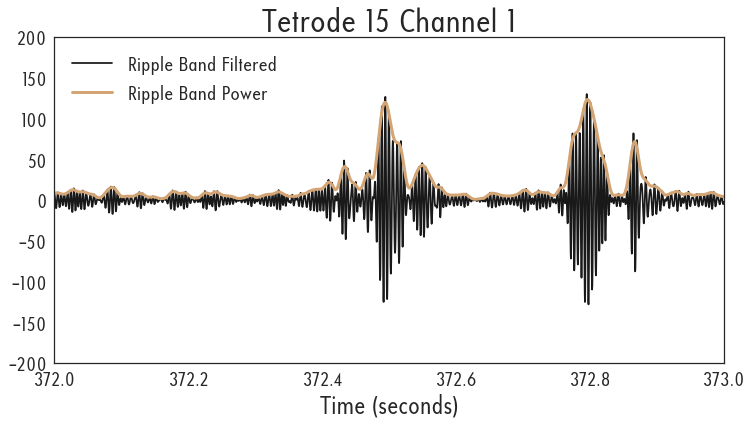

In [ ]:
#just wanna look at a lil portion
ax = npl.plot(rbf[0,0],label="Ripple Band Filtered")
npl.plot(envelope[0,0],label="Ripple Band Power",color=npl.colors.cows.jersey,lw=3)
ax.set_title("Tetrode 15 Channel 1")
ax.set_xlabel("Time (seconds)")
ax.set_ylim(-200,200)
ax.set_xlim(372,373)
ax.legend()

# Find Ripples!

In [ ]:
#let's just go ahead and find ripples
#ripple detection across channels!
ripple_epochs = []
ripple_maximums = []
ripple_events_list = []
for i,cow in enumerate(envelope.signals):
    #find ripples! Ripple band power signal 3 sd above mean for 15 ms 
    ripple_bounds, ripple_maxes, ripple_events = \
                                nel.utils.get_events_boundaries(cow.ydata, \
                                minThresholdLength = 0.015, ds=1/cow.fs)
    ripple_maximums.append(ripple_maxes)
    ripple_events_list.append(nel.EpochArray((ripple_events/cow.fs)+cow.time[0]))
    #ripple bounds stored as epoch arrays
    ripple_epochs.append(nel.EpochArray((ripple_bounds/cow.fs)+cow.time[0]))

In [ ]:
envelope_ripple_epochs_t15c1 = envelope[0,0][ripple_events_list[0][0:500]]

/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


In [ ]:
envelope_ripple_epochs_t15c1

<AnalogSignalArray at 0x7fb800523128: 1 signals (500 segments)> for a total of 15.985 seconds

In [ ]:
nel.ResultsContainer(envelope_ripple_epochs_t15c1=envelope_ripple_epochs_t15c1).\
                    save_pkl("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/syntheticRippleAnalysis/envelope_ripple_epochs_t15c1.pkl",\
                    zip=False,protocol=4, overwrite=True)

Alright, data is loaded up! Let's move on!

# Generate Synthetic Ripples
- Generate random numbers from a normal distribution
- Filter numbers to ripple band
- Scale standard deviation to real ripple standard devaition
- Take signal envelope

In [ ]:
#ripple band filtered noise
normal_equiv_rbf = nel.filtering.ripple_band_filter(np.random.randn(rbf.n_samples),fs=rbf.fs)
normal_equiv_rbf /= np.std(normal_equiv_rbf)
normal_equiv_rbf *= rbf[0,0].std()
#power envelope via Hilbert Transform
normal_equiv_envelope = nel.utils.signal_envelope1D(normal_equiv_rbf,fs=rbf.fs)

In [ ]:
np.save("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/normal_equiv_rbf.npz", normal_equiv_rbf)

(-200, 200)

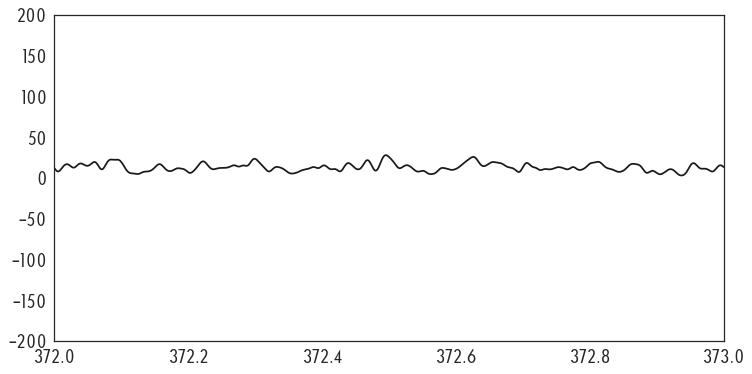

In [ ]:
plt.plot(rbf.time,normal_equiv_envelope)
plt.xlim(372,373)
plt.ylim(-200,200)

<div class="alert alert-info">
This is just the underlying noise within the ripple band...
Let's replicate the histogram plot in the discussion section of the UT L&M poster. Prior to injecting ripples! Aka replicate Caleb's analysis
</div>

In [ ]:
#normalize data for histograms
NormalizedRipple = (envelope.ydata[0] - envelope[0,0].mean())/envelope[0,0].std()
NormalizedSynth = (normal_equiv_envelope - np.mean(normal_equiv_envelope))/np.std(normal_equiv_envelope)

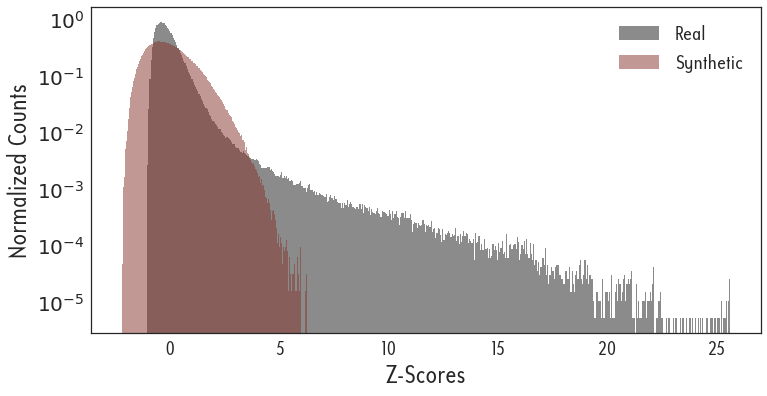

In [ ]:
#histogram!
#This is actually too much data to plot histograms of so let's just
#look at a quarter of it
plt.hist(NormalizedRipple[int(len(NormalizedRipple)*2/4):int(len(NormalizedRipple)*3/4)],alpha=0.5,bins=500,normed=1,label="Real")
plt.hist(NormalizedSynth[int(len(NormalizedSynth)*2/4):int(len(NormalizedSynth)*3/4)],alpha=0.5,bins=500,normed=1,label="Synthetic")
plt.gca().set_yscale('log')
plt.xlabel("Z-Scores")
plt.ylabel("Normalized Counts")
plt.legend()
plt.show()

<div class="alert alert-success">
This looks the same-ish. I want to do one more thing before injecting ripples at will...Let's take a look at the histogram above but with ripple epochs marked.
</div>

In [ ]:
NormalizedRippleEpochs = (envelope_ripple_epochs_t15c1.ydata[0] - envelope[0,0].mean())/envelope[0,0].std()

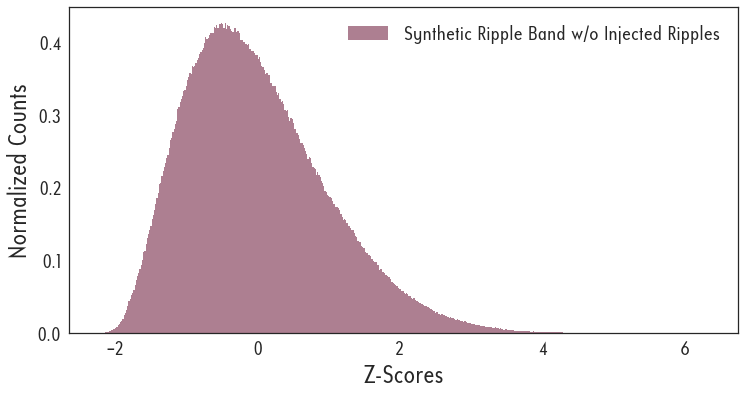

In [ ]:
# plt.hist(NormalizedRippleEpochs,alpha=1,bins=500,normed=1,label="Ripple Epochs",color=npl.colors.cows.jersey)
# plt.hist(NormalizedRipple[int(len(NormalizedRipple)*2/4):int(len(NormalizedRipple)*3/4)],alpha=0.5,bins=500,label="Ripple Band LFP",color=npl.colors.cows.angus)
plt.hist(NormalizedSynth[int(len(NormalizedSynth)*2/4):int(len(NormalizedSynth)*3/4)],alpha=0.5,bins=500,normed=1,label="Synthetic Ripple Band w/o Injected Ripples",color=npl.colors.cows.texas_aggie)
# plt.gca().set_yscale('log')
plt.xlabel("Z-Scores")
plt.ylabel("Normalized Counts")
# plt.xlim(-3,20)
plt.legend()
plt.show()

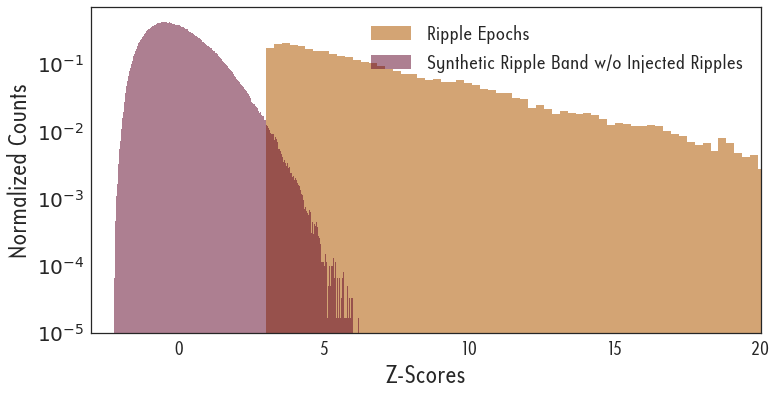

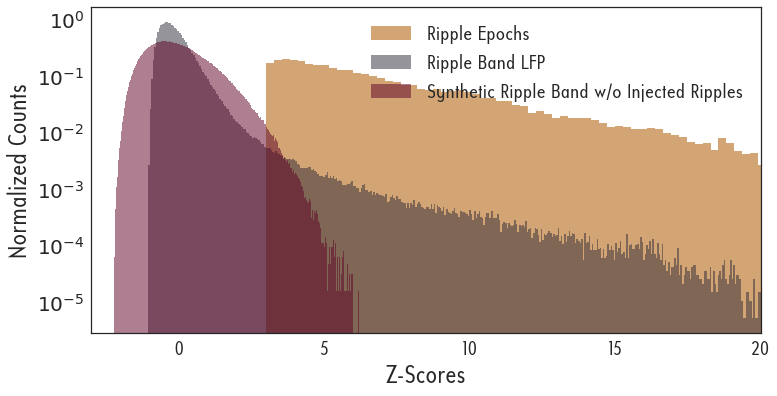

In [ ]:
#histogram!
#This is actually too much data to plot histograms of so let's just
#look at a quarter of it
plt.hist(NormalizedRippleEpochs,alpha=1,bins=500,normed=1,label="Ripple Epochs",color=npl.colors.cows.jersey)
# plt.hist(NormalizedRipple[int(len(NormalizedRipple)*2/4):int(len(NormalizedRipple)*3/4)],alpha=0.5,bins=500,label="Ripple Band LFP",color=npl.colors.cows.angus)
plt.hist(NormalizedSynth[int(len(NormalizedSynth)*2/4):int(len(NormalizedSynth)*3/4)],alpha=0.5,bins=500,normed=1,label="Synthetic Ripple Band w/o Injected Ripples",color=npl.colors.cows.texas_aggie)
plt.gca().set_yscale('log')
plt.xlabel("Z-Scores")
plt.ylabel("Normalized Counts")
plt.xlim(-3,20)
plt.legend()
plt.show()

#histogram!
#This is actually too much data to plot histograms of so let's just
#look at a quarter of it
plt.hist(NormalizedRippleEpochs,alpha=1,bins=500,normed=1,label="Ripple Epochs",color=npl.colors.cows.jersey)
plt.hist(NormalizedRipple[int(len(NormalizedRipple)*2/4):int(len(NormalizedRipple)*3/4)],alpha=0.5,bins=500,normed=1,label="Ripple Band LFP",color=npl.colors.cows.angus)
plt.hist(NormalizedSynth[int(len(NormalizedSynth)*2/4):int(len(NormalizedSynth)*3/4)],alpha=0.5,bins=500,normed=1,label="Synthetic Ripple Band w/o Injected Ripples",color=npl.colors.cows.texas_aggie)
plt.gca().set_yscale('log')
plt.xlabel("Z-Scores")
plt.ylabel("Normalized Counts")
plt.xlim(-3,20)
plt.legend()
plt.show()

<div class="alert alert-success">
This is pretty cool. We see the cannonical ripple epochs here along with the synthetic. One more thing that'd be cool to see is the how well the "non-ripple" epochs that exceed z-score of 3 threshold for but for less than 15 ms overlap with the ones that meet the canonical definition. My expectation is that it'll be similar to the ripple epochs histogram above but with a higher peak at the z-score 3 threshold. This might tell us something interesting about limitations of accuracy based on the canonical definition?
</div>

In [ ]:
#Same ripple detection as done in the ripple detection section but this just simply looks at the threshold crossing
#without a time requirement.
#let's just go ahead and find ripples
#ripple detection across channels!
ripple_epochs_thresh3cross = []
ripple_maximums_thresh3cross = []
ripple_events_list_thresh3cross = []
for i,cow in enumerate(envelope.signals):
    #find threshold crossings above z-score 3
    ripple_bounds_thresh3cross, ripple_maxes_thresh3cross, ripple_events_thresh3cross = \
                                nel.utils.get_events_boundaries(cow.ydata, maxLength=0.015, \
                                PrimaryThreshold=np.mean(cow.ydata)+3*np.std(cow.ydata), \
                                SecondaryThreshold=np.mean(cow.ydata)+3*np.std(cow.ydata),\
                                ds=1/cow.fs)
    ripple_maximums_thresh3cross.append(ripple_maxes_thresh3cross)
    ripple_events_list_thresh3cross.append(nel.EpochArray((ripple_events_thresh3cross/cow.fs)+cow.time[0]))
    #ripple bounds stored as epoch arrays
    ripple_epochs_thresh3cross.append(nel.EpochArray((ripple_bounds_thresh3cross/cow.fs)+cow.time[0]))
envelope_ripple_epochs_t15c1_thresh3cross = envelope[0,0][ripple_events_list_thresh3cross[0][0:200]]

/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


In [ ]:
NormalizedRippleEpochs_thresh3cross = (envelope_ripple_epochs_t15c1_thresh3cross.ydata[0] - envelope[0,0].mean())/envelope[0,0].std()

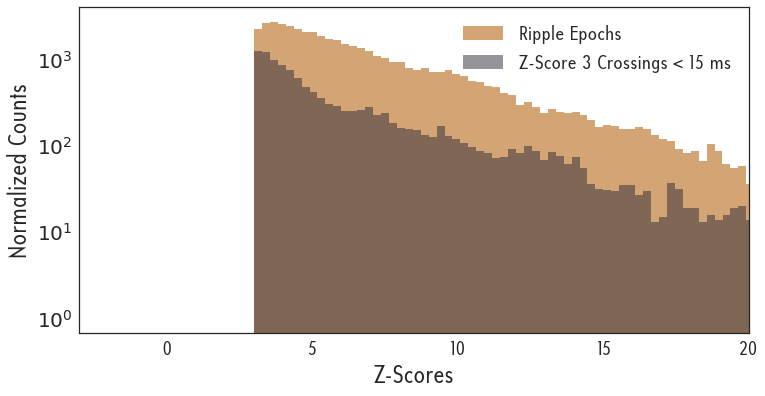

In [ ]:
#histogram!
#This is actually too much data to plot histograms of so let's just
#look at a quarter of it
plt.hist(NormalizedRippleEpochs,alpha=1,bins=500,normed=0,label="Ripple Epochs",color=npl.colors.cows.jersey)
plt.hist(NormalizedRippleEpochs_thresh3cross,alpha=0.5,bins=500,normed=0,label="Z-Score 3 Crossings < 15 ms",color=npl.colors.cows.angus)
# plt.hist(NormalizedRipple[int(len(NormalizedRipple)*2/4):int(len(NormalizedRipple)*3/4)],alpha=0.5,bins=500,label="Ripple Band LFP",color=npl.colors.cows.angus)
# plt.hist(NormalizedSynth[int(len(NormalizedSynth)*2/4):int(len(NormalizedSynth)*3/4)],alpha=0.5,bins=500,label="Synthetic Ripple Band w/o Injected Ripples",color=npl.colors.cows.texas_aggie)
plt.gca().set_yscale('log')
plt.xlabel("Z-Scores")
plt.ylabel("Normalized Counts")
plt.xlim(-3,20)
plt.legend()
plt.show()

<div class="alert alert-success">
That's a lot of false detections but somewhat expected. I'm going to take a quick look at the same plot as above but with a z-score 4 threshold...I think I should really do a timing and threshold analysis and draw up curves with varying threshold timing requirements across threshold and then look at detection metrics. That would probably reveal some trade-off points worth noting (maybe not worth doing as of right now).
</div>

In [ ]:
#Same ripple detection as done in the ripple detection section but this just simply looks at the threshold crossing
#without a time requirement.
#let's just go ahead and find ripples
#ripple detection across channels!
ripple_epochs_thresh4cross = []
ripple_maximums_thresh4cross = []
ripple_events_list_thresh4cross = []
for i,cow in enumerate(envelope.signals):
    #find threshold crossings above z-score 3
    ripple_bounds_thresh4cross, ripple_maxes_thresh4cross, ripple_events_thresh4cross = \
                                nel.utils.get_events_boundaries(cow.ydata, maxLength=0.015, \
                                PrimaryThreshold=np.mean(cow.ydata)+4*np.std(cow.ydata), \
                                SecondaryThreshold=np.mean(cow.ydata)+4*np.std(cow.ydata),\
                                ds=1/cow.fs)
    ripple_maximums_thresh4cross.append(ripple_maxes_thresh4cross)
    ripple_events_list_thresh4cross.append(nel.EpochArray((ripple_events_thresh4cross/cow.fs)+cow.time[0]))
    #ripple bounds stored as epoch arrays
    ripple_epochs_thresh4cross.append(nel.EpochArray((ripple_bounds_thresh4cross/cow.fs)+cow.time[0]))

#This is actually too much data to to handle so let's just look at 200 events.
envelope_ripple_epochs_t15c1_thresh4cross = envelope[0,0][ripple_events_list_thresh4cross[0][0:200]]

NormalizedRippleEpochs_thresh4cross = (envelope_ripple_epochs_t15c1_thresh4cross.ydata[0] - envelope[0,0].mean())/envelope[0,0].std()


/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


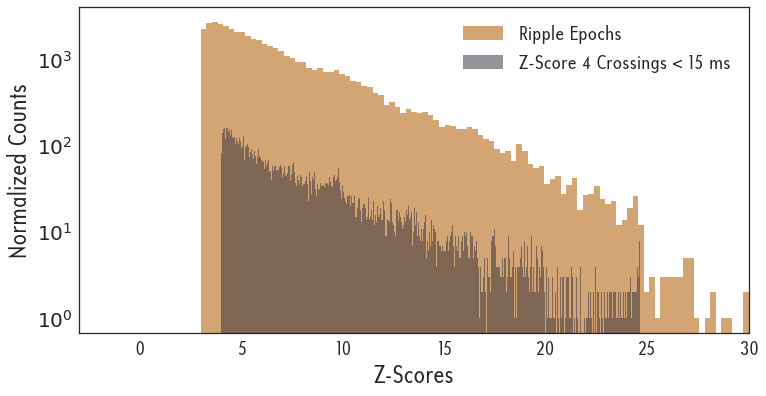

In [ ]:
#histogram!
plt.hist(NormalizedRippleEpochs,alpha=1,bins=500,normed=0,label="Ripple Epochs",color=npl.colors.cows.jersey)
plt.hist(NormalizedRippleEpochs_thresh4cross,alpha=0.5,bins=500,normed=0,label="Z-Score 4 Crossings < 15 ms",color=npl.colors.cows.angus)
# plt.hist(NormalizedRipple[int(len(NormalizedRipple)*2/4):int(len(NormalizedRipple)*3/4)],alpha=0.5,bins=500,label="Ripple Band LFP",color=npl.colors.cows.angus)
# plt.hist(NormalizedSynth[int(len(NormalizedSynth)*2/4):int(len(NormalizedSynth)*3/4)],alpha=0.5,bins=500,label="Synthetic Ripple Band w/o Injected Ripples",color=npl.colors.cows.texas_aggie)
plt.gca().set_yscale('log')
plt.xlabel("Z-Scores")
plt.ylabel("Normalized Counts")
plt.xlim(-3,30)
plt.legend()
plt.show()

<div class="alert alert-success">
Once again, somewhat expected...you're going to detect less events with a higher threshold. With that said all of these detections are less than 15 ms so they are just noise events here. 
</div>

<div class="alert alert-warning">
All histograms of threshold crossing ripple detections (not canonical ripples) only look at the first 500 ripples because of memory considerations. Memory as in computer memory (RAM) not rodent memory but we _do_ care about Cavardossi's memories!
</div>

## Finally, let's inject the fake ripples!
- Pipeline for generating ripples of various amplitudes
- Pipeline for generating ripples with various durations? ( I'm not gonna do this atm because I don't think it matters too much. I'll wait till later discussions about ripple amplitude vs duration and after we discuss whether or not it's worth looking into the statistical significance of the "split".

### Development!

In [ ]:
normal_equiv_rbf.shape

(14408422,)

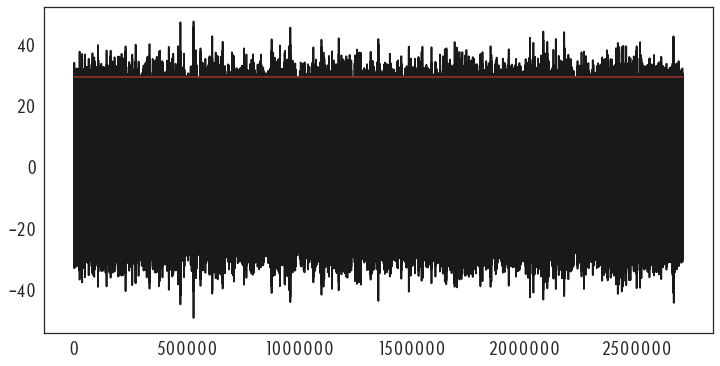

In [ ]:
plt.plot(normal_equiv_rbf[0:int(3000*60*15)] )
plt.plot(np.ones(normal_equiv_rbf[0:int(3000*60*15)] .shape)*(np.mean(normal_equiv_rbf[0:int(3000*60*15)])+(3*np.std(normal_equiv_rbf[0:int(3000*60*15)]))))
plt.show()

In [ ]:
eventLength = np.mean(ripple_events_list[0].durations) #event defined as ripple band power staying above z-score 3
eventLength

0.029072723101629727

In [ ]:
rippleBoundAvg = np.mean(ripple_epochs[0].durations)
rippleBoundAvg

0.099612296398260983

In [ ]:
eventLength/rippleBoundAvg #29% of the ripple bounds are when the "event" transpires aka when we are above the 
                           #z-score 3 threshold

0.29185877801063598

In [ ]:
(eventLength/2 / np.sqrt(-2*np.log(eventLength/rippleBoundAvg))) #what should sigma be???

0.0092624550760707618

In [ ]:
t = np.arange(-round(4*(eventLength/2 / np.sqrt(-2*np.log(eventLength/rippleBoundAvg))) *3000), round(4*(eventLength/2 / np.sqrt(-2*np.log(eventLength/rippleBoundAvg))) *3000))/3000
t[-1]-t[0]

0.073666666666666658

In [ ]:
t.size

2401

In [ ]:
envelope[0,0].mean()+(3*envelope[0,0].std())

36.367578186428176

In [ ]:
winSize = round(4 * 0.1 * 3000)
t = np.arange(-winSize, winSize+1) / 3000

In [ ]:
(syntheticrippleenvelope_test/syntheticrippleenvelope_test.max()).mean(), 3*(syntheticrippleenvelope_test/syntheticrippleenvelope_test.max()).std()

(0.15659901757378161, 0.88084094735456631)

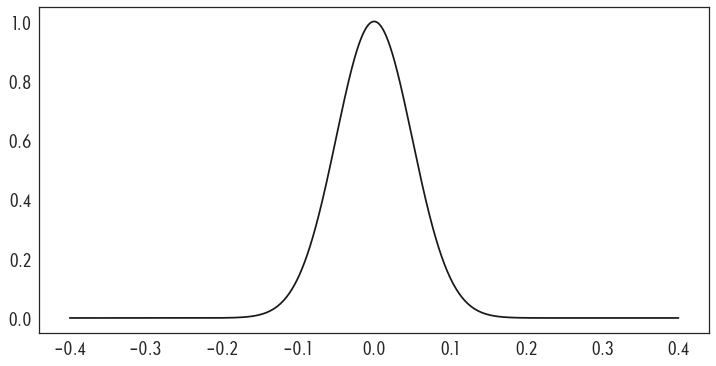

In [ ]:
#scale specifies standard deviation. loc specifies mean
syntheticrippleenvelope_test =scipy.stats.norm.pdf(t,loc=0,scale=0.05)
plt.plot(t,syntheticrippleenvelope_test/syntheticrippleenvelope_test.max())
plt.show()

In [ ]:
boundariees = np.squeeze(np.where(syntheticrippleenvelope_test>envelope[0,0].mean()+(3*envelope[0,0].std())))
t[boundariees[-1]] - t[boundariees[0]]

IndexError: index -1 is out of bounds for axis 0 with size 0

### NEW RIPPLE GENERATION FUNCTIONS! RUN CELL BELOW!

In [ ]:
normal_equiv_rbf = np.load("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/normal_equiv_rbf.npz.npy")

In [ ]:
def generate_SWR_new(PeakLevel=6, FS=3000, FRipple=200, nStdDevs=4, PhaseOffset=0):
    """
        Virtually identical to original but length of ripple event is 133ms specified by
        window size. This enables coming back down to the mean on either side at ~100ms
    """
    winSize = round(400)
    t = np.arange(-winSize, winSize+1) / FS
    envelope = scipy.stats.norm.pdf(t,loc=0,scale=0.03)
    envelope = (envelope/envelope.max()) * PeakLevel
    carrier = np.sin(2*np.pi*FRipple*t + PhaseOffset) * envelope
    return carrier, t, envelope

def generate_synthetic_ripple_signal_new(peak, add_ripples_to_me=None, numberRipples=150):
    """
        peak is specified by number of standard devaitions above the mean for the ripple peak. 
        background noise is scaled down by a value, beta, to make the peak of the ripple as specied. 
        beta = ( (6*sigma) + mu ) / ( mu + peak*sigma )
    """
    #ripple generation pipeline
    added_ripples = None
    if(add_ripples_to_me is None): 
        added_ripples = normal_equiv_rbf.copy()[0:int(3000*60*15)] #15 minutes of ripples!
    else:
        added_ripples = add_ripples_to_me.copy()
#     beta = ((6*np.std(added_ripples)) + np.mean(added_ripples)) / \
#            (np.mean(added_ripples) + (peak*np.std(added_ripples)))
#     peak = envelope[0,0].mean() + peak*envelope[0,0].std() #update peak to peak level prior to scaling
#     added_ripples *= beta
    
    NRipsToAdd = numberRipples
    PhaseOffsets = np.random.rand(NRipsToAdd)*2*np.pi
    EdgeExclude = 3000*10
    RippleInsertionIdx = np.rint(np.linspace(EdgeExclude, len(added_ripples) - \
                                             EdgeExclude, NRipsToAdd))

    for k in range(NRipsToAdd):
        x,t, _ = generate_SWR_new(PeakLevel=peak, PhaseOffset=PhaseOffsets[k],)
        added_ripples[(np.rint(t * 3000) + RippleInsertionIdx[k]).astype(int)] += x
    return added_ripples

### Plot and check out!

In [ ]:
x,t, e = generate_SWR_new(PeakLevel=6,)
plt.plot(t,e,lw=15)

In [ ]:
npl.setup()
npl.set_palette(npl.colors.cows)
npl.setup(font='Universalis ADF Cd Std', font_scale=2, palette=npl.colors.cows, style='white',\
         rc=({'figure.figsize': (12, 4), 'font.size': 18, 'axes.labelsize': 20, \
             'axes.titlesize':30, 'legend.fontsize': 20, 'ytick.labelsize': 20, 'xtick.labelsize': 20}))

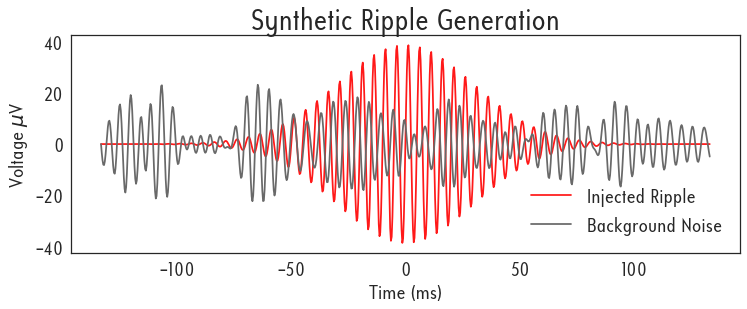

In [ ]:
x,t, e = generate_SWR_new(PeakLevel=9.738546176904627*4,)
plt.plot(1000*t,x,color='red',alpha=0.9,label='Injected Ripple')
plt.plot(t*1000,normal_equiv_rbf[0:len(t)],color='dimgray',label='Background Noise')
plt.title("Synthetic Ripple Generation")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage $\mu$V")
plt.legend()
plt.savefig("/home/shayok/Documents/Posters/SFN2017/syntheticRippleGeneration.svg")
plt.show()

(-0.15, 0.15)

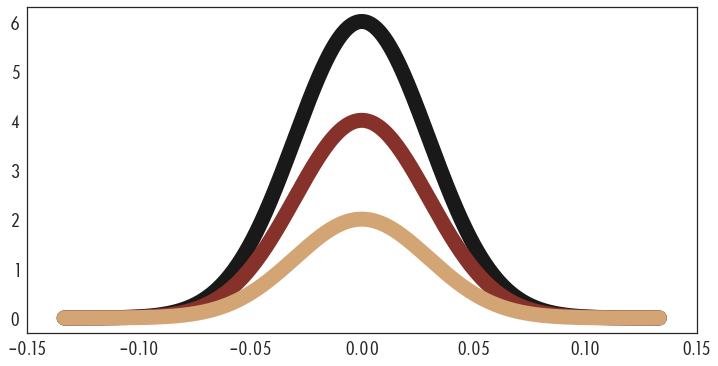

In [ ]:
x,t, e = generate_SWR_new(PeakLevel=6,)
plt.plot(t,e,lw=15)
x,t, e = generate_SWR_new(PeakLevel=4,)
plt.plot(t,e,lw=15)
x,t, e = generate_SWR_new(PeakLevel=2,)
plt.plot(t,e,color = npl.colors.cows.jersey,lw=15)
plt.xlim([-0.15,0.15])

In [ ]:
from scipy.io.wavfile import write
write('/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/syntheticRippleAudio/noise.wav', 3000, normal_equiv_rbf[0:int(3000*60*2)]/75)

In [ ]:
cow = nel.AnalogSignalArray(normal_equiv_rbf[0:int(3000*60*2)]/75,timestamps=np.arange(0,len(normal_equiv_rbf[0:int(3000*60*2)]/75))/3000,fs=3000,\
                                labels=['Synthetic'])
cow.add_signal(nel.filtering.ripple_band_filter(cow,),label=['Ripple Band Filtered'])
cow.add_signal(nel.utils.signal_envelope1D(cow[0,1]),label='Enveloped')
meeeaaann = cow[0,2].mean()
staandard_dev = cow[0,2].std()

In [ ]:
smoothed_envelope_simulated, _ = ripple_filtering.rippleBandFilterSimulated(normal_equiv_rbf[0:int(3000*60*2)]/75, np.arange(0,len(normal_equiv_rbf[0:int(3000*60*2)]/75))/3000, 3000, ripple_filtering.bandpassFilterTaps, ripple_filtering.lowpassFilterTaps)
np.mean(smoothed_envelope_simulated), np.std(smoothed_envelope_simulated)

(0.10080409672414296, 0.04748917076565505)

In [ ]:
4061*0.195

791.895

In [ ]:
9430*0.195

1838.8500000000001

In [ ]:
np.mean(smoothed_envelope_simulated), np.std(smoothed_envelope_simulated)/0.195

(0.10080409672414296, 0.24353420905464127)

In [ ]:
(np.mean(smoothed_envelope_simulated) + (5*np.std(smoothed_envelope_simulated)))

0.33824995055241824

In [ ]:
PEAK = 10
peaksize = meeeaaann + (PEAK*staandard_dev)
added_ripples = generate_synthetic_ripple_signal_new(\
                                                         peak=peaksize,\
                                                         add_ripples_to_me=normal_equiv_rbf[0:int(3000*60*15)].copy()/75 , \
                                                         numberRipples=500\
                                                        )

In [ ]:
write('/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/syntheticRippleAudio/ripples10STD.wav', 3000, added_ripples)

(15, 20)

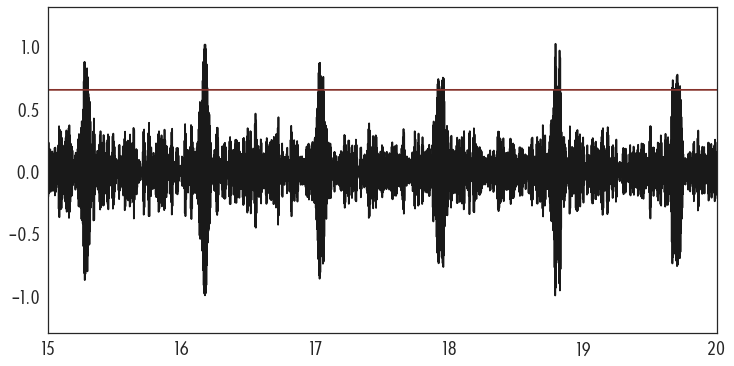

In [ ]:
plt.plot(np.arange(len(added_ripples[0:int(3000*60*2)]))/3000,added_ripples[0:int(3000*60*2)])
plt.plot(np.arange(len(added_ripples[0:int(3000*60*2)]))/3000,np.ones(added_ripples[0:int(3000*60*2)].shape)\
        *np.mean(normal_equiv_rbf[0:int(3000*60*2)]/75) + (5* np.std(normal_equiv_rbf[0:int(3000*60*2)]/75)))
plt.xlim(15,20)

In [ ]:

cow = nel.AnalogSignalArray(added_ripples,timestamps=np.arange(0,len(added_ripples))/3000,fs=3000,\
                            labels=['Synthetic'])
cow.add_signal(nel.filtering.ripple_band_filter(cow,),label=['Ripple Band Filtered'])
cow.add_signal(nel.utils.signal_envelope1D(cow[0,1]),label='Enveloped')

ripple_epochs_sim = []
ripple_maximums_sim = []
ripple_events_list_sim = []
#find ripples! Ripple band power signal 3 sd above mean for 15 ms 
ripple_bounds_sim, ripple_maxes_sim, ripple_events_sim = \
                            nel.utils.get_events_boundaries(cow[0,2].ydata, \
                            minThresholdLength = 0.015, ds=1/cow.fs)
ripple_maximums_sim.append(ripple_maxes_sim)
ripple_events_list_sim.append(nel.EpochArray((ripple_events_sim/cow.fs)+cow.time[0]))
#ripple bounds stored as epoch arrays
ripple_epochs_sim.append(nel.EpochArray((ripple_bounds_sim/cow.fs)+cow.time[0]))

In [ ]:
np.mean(ripple_epochs_sim[0][np.where(ripple_epochs_sim[0].durations > 0.1)[0]].durations),\
np.std(ripple_epochs_sim[0][np.where(ripple_epochs_sim[0].durations > 0.1)[0]].durations),\
np.size(ripple_epochs_sim[0][np.where(ripple_epochs_sim[0].durations > 0.1)[0]].durations),\
np.mean(ripple_epochs_sim[0].durations),\
len(ripple_epochs_sim[0])

(0.11982379349046166, 0.017695749379532145, 297, 0.10098189563365395, 626)

In [ ]:
ripple_epochs_sim[0].time

array([[   9.93133333,   10.06166667],
       [  10.817     ,   10.91566667],
       [  12.60666667,   12.68333333],
       ..., 
       [ 887.30533333,  887.423     ],
       [ 888.186     ,  888.27266667],
       [ 889.04033333,  889.23433333]])

(9.0, 20)

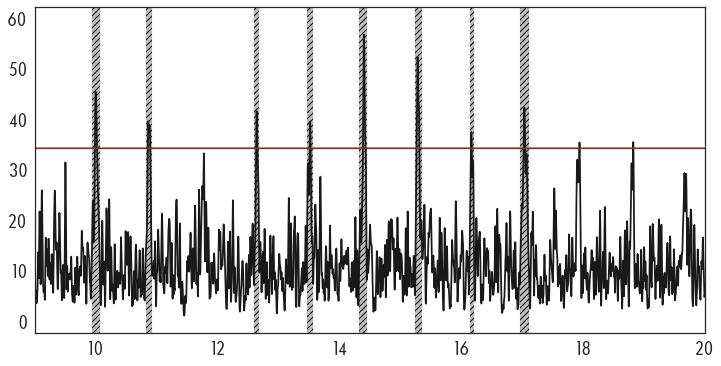

In [ ]:
ax = npl.plot(cow[0,2])
plt.plot(np.arange(len(added_ripples))/3000,(cow[0,2].mean()+(3*cow[0,2].std()))*np.ones(cow[0,2].time.shape))
npl.epochplot(ripple_epochs_sim[0])
ax.set_xlim([9.0,20])

In [ ]:
cow[0,2].mean()+(PEAK*cow[0,2].std())

45.95901207006828

In [ ]:
ripple_maxes_sim

array([ 60.24902171,  53.03279378,  65.04451965,  57.11630888,
        51.85010406,  64.12800822,  51.30453024,  60.91650074,
        50.77917596,  57.33578203,  52.95862563,  55.82217614,
        60.98067591,  59.3505141 ,  56.8753442 ,  53.36836405,
        77.01983104,  69.84338984,  69.53767595,  59.88029251,
        62.61793792,  47.629288  ,  61.27389344,  56.64464563,
        60.83087376,  56.90758286,  68.79659087,  62.3835546 ,
        53.49021918,  40.05664013,  58.83315175,  77.24076941,
        59.16961591,  53.53490826,  54.33359506,  62.94425307,
        66.60540903,  65.52916657,  50.17454788,  64.28621288,
        59.54683849,  57.61665298,  59.45805148,  52.23499018,
        52.12446112,  53.65701046,  62.15199047,  62.72694668,
        53.22062842,  56.91693416,  58.49704757,  53.63047346,
        68.42477625,  64.09587144,  58.23751636,  63.33859591,
        56.23612303,  50.27663121,  67.57061595,  64.9716518 ,
        61.94337915,  66.70905141,  61.6706396 ,  58.03

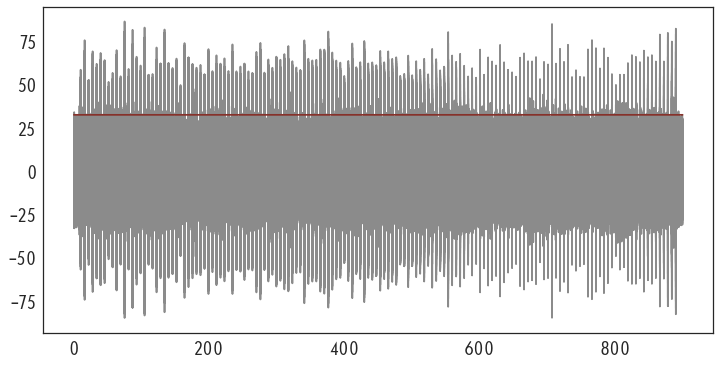

In [ ]:
added_ripples = generate_synthetic_ripple_signal_new(peak = 5)
ax = plt.gca()
plt.plot(np.arange(len(added_ripples))/3000,added_ripples,alpha=0.5)
plt.plot(np.arange(len(added_ripples))/3000,np.ones(added_ripples.shape)*(np.mean(added_ripples)+(3*np.std(added_ripples))))
ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.show()

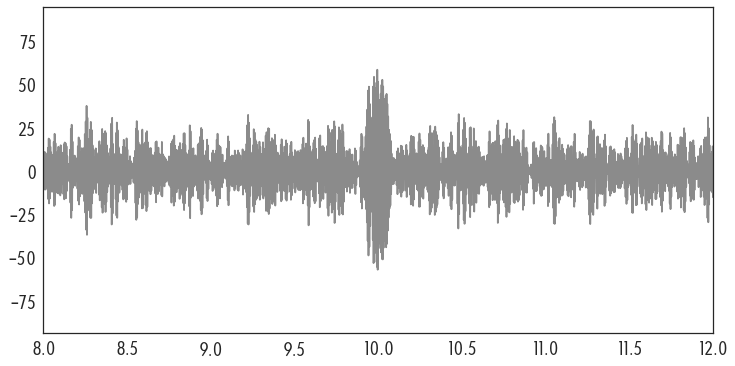

In [ ]:
plt.plot(np.arange(len(added_ripples))/3000,added_ripples,alpha=0.5)
plt.xlim(8,12)
plt.show()

# Detect Synthetic Ripples with Modified Simulated and Canonical Algorithm

<b>Loop through while incrementing size of simulated ripple amplitude</b>
- Canonical detection
- Write to file
- Real-time simulated detection with cpp program
- Store data

## True Positive & False Positives & Latencies with Varying Simulated Amplitudes 
## AND Simulated ripple detection!
call cpp program! (This is just easier for me than Cython...)<br><br>
<b>NOTE: Remember to compile cpp program with `g++ -std=c++11 -o ripple_detections main.cpp`. Also, file locations to data need to be modified within the cpp code. It's a #define up top so easy to change. The files that'll be generated by the cpp program can be specified by the command line arguement as is done here. </b> <br><br>
- These will be heatmaps based on values with each simulated amplitude having multiple detection thresholds and individual values for the metrics. 

In [ ]:
smoothed_envelope_simulated, _ = ripple_filtering.rippleBandFilterSimulated(normal_equiv_rbf, np.arange(0,len(normal_equiv_rbf))/3000, 3000, ripple_filtering.bandpassFilterTaps, ripple_filtering.lowpassFilterTaps)
np.mean(smoothed_envelope_simulated), np.std(smoothed_envelope_simulated)

(7.5374361055624668, 3.5490325689767643)

In [ ]:
cow = nel.AnalogSignalArray(normal_equiv_rbf,timestamps=np.arange(0,len(normal_equiv_rbf))/3000,fs=3000,\
                                labels=['Synthetic'])
cow.add_signal(nel.filtering.ripple_band_filter(cow,),label=['Ripple Band Filtered'])
cow.add_signal(nel.utils.signal_envelope1D(cow[0,1]),label='Enveloped')

<AnalogSignalArray at 0x7fc9ef3bc080: 3 signals> for a total of 1:20:02:807 hours

In [ ]:
cow[0,2].mean(), cow[0,2].std()

(10.5205727732693, 4.787166613758323)

In [ ]:
meeeaaann = cow[0,2].mean()
staandard_dev = cow[0,2].std()

In [ ]:
addemtome = normal_equiv_rbf
for i in tqdm(range(35)):
    peaksize = (i*0.15)+5 #vary ripple amplitude from 5 to 12 std above the mean
    peaksize = meeeaaann + (peaksize*staandard_dev)
    added_ripples = generate_synthetic_ripple_signal_new(\
                                                         peak=peaksize,\
                                                         add_ripples_to_me=normal_equiv_rbf, \
                                                         numberRipples=500\
                                                        )
    cow = nel.AnalogSignalArray(added_ripples,timestamps=np.arange(0,len(added_ripples))/3000,fs=3000,\
                                labels=['Synthetic'])
    cow.add_signal(nel.filtering.ripple_band_filter(cow,),label=['Ripple Band Filtered'])
    cow.add_signal(nel.utils.signal_envelope1D(cow[0,1]),label='Enveloped')

    #let's just go ahead and find ripples
    #ripple detection across channels!
    ripple_epochs_sim = []
    ripple_maximums_sim = []
    ripple_events_list_sim = []
    #find ripples! Ripple band power signal 3 sd above mean for 15 ms 
    ripple_bounds_sim, ripple_maxes_sim, ripple_events_sim = \
                                nel.utils.get_events_boundaries(cow[0,2].ydata, \
                                minThresholdLength = 0.015, ds=1/cow.fs)
    ripple_maximums_sim.append(ripple_maxes_sim)
    ripple_events_list_sim.append(nel.EpochArray((ripple_events_sim/cow.fs)+cow.time[0]))
    #ripple bounds stored as epoch arrays
    ripple_epochs_sim.append(nel.EpochArray((ripple_bounds_sim/cow.fs)+cow.time[0]))
    #store canonical ripple starts and ends
    np.savetxt("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/syntheticRippleAnalysis/rippleBoundsStart.out",nel.EpochArray(ripple_bounds_sim).starts,fmt='%10.5f')
    np.savetxt("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/syntheticRippleAnalysis/rippleBoundsEnd.out",nel.EpochArray(ripple_bounds_sim).stops,fmt='%10.5f')

    #simulated real-time detections!
    #filter and store to file
    smoothed_envelope_simulated, rippleData_simulated = ripple_filtering.rippleBandFilterSimulated(cow[0,0].ydata, cow.time, cow.fs, ripple_filtering.bandpassFilterTaps, ripple_filtering.lowpassFilterTaps)
    smoothed_envelope_simulated = smoothed_envelope_simulated.squeeze()
    rippleData_simulated = rippleData_simulated.squeeze()
    np.savetxt("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/syntheticRippleAnalysis/smoothed_envelope_simulated.out",smoothed_envelope_simulated,fmt='%10.5f')

    #call cpp program and feed in filenames!!
    os.system("mkdir /home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/syntheticRippleAnalysis/ripplepeak"+str(int(round((i*0.15)+5,3)*100)))
    os.system("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/DataAnalysisScripts/simulatedRippleDetectionsSingleChan/ripple_detections "+"/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/syntheticRippleAnalysis/ripplepeak"+str(int(round((i*0.15)+5,3)*100)))

100%|██████████| 35/35 [6:40:15<00:00, 687.55s/it]  


## Alright, let's take a look at our results!!

In [ ]:
#load up the data
synthRipAmpl_ind = []
ripDetectThresh_ind = []
synthRipAmpl = []
ripDetectThresh = []
detectLat = []
relDetectLat = []
fpPercent = []
fpRate = []
tpPercent = []
for i in tqdm(range(35)): #loop thru all file directories created
    peaksize = (i*0.15)+5 #vary ripple amplitude from 5 to 12 std above the mean
    filedir = "/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/syntheticRippleAnalysis/ripplepeak"\
               +str(int(round((i*0.15)+5,3)*100))+"/"
    #loop thru all metrics generated
    #store 3 dimensional data (metric value, synthetic ripple amplitude, ripple detection threshold)
    
    for ii in range(25): #looping thru metrics
        thresh_file_ext = str(int(((ii*0.25)+3)*100))
        detectLat_file = filedir+"detectionLatency"+thresh_file_ext+".out"
        relDetectLat_file = filedir+"relativeDetectionLatency"+thresh_file_ext+".out"
        fpPercent_file = filedir+"fpPercent"+thresh_file_ext+".out"
        fpRate_file = filedir+"fpRate"+thresh_file_ext+".out"
        tpRate_file = filedir+"tpRate"+thresh_file_ext+".out"
        
        synthRipAmpl.append(float(round((i*0.15)+5,3)))
        synthRipAmpl_ind.append(i)
        ripDetectThresh.append(float(((ii*0.25)+3)))
        ripDetectThresh_ind.append(ii)
        detectLat.append(np.loadtxt(detectLat_file))
        relDetectLat.append(np.loadtxt(relDetectLat_file))
        fpPercent.append(np.loadtxt(fpPercent_file)*100)
        fpRate.append(np.loadtxt(fpRate_file))
        tpPercent.append(np.loadtxt(tpRate_file)*100)
        
synthRipAmpl_ind = np.asarray(synthRipAmpl_ind)
ripDetectThresh_ind = np.asarray(ripDetectThresh_ind)
synthRipAmpl = np.asarray(synthRipAmpl)
ripDetectThresh = np.asarray(ripDetectThresh)
detectLat = np.asarray(detectLat)
relDetectLat = np.asarray(relDetectLat)
fpPercent = np.asarray(fpPercent)
fpRate = np.asarray(fpRate)
tpPercent = np.asarray(tpPercent)

100%|██████████| 35/35 [00:00<00:00, 127.16it/s]


In [ ]:
#my plot settings!
%matplotlib inline
npl.setup()
npl.set_palette(npl.colors.cows) #moo!
npl.setup(font='Universalis ADF Cd Std', font_scale=2, palette=npl.colors.cows, style='white',\
         rc=({'figure.figsize': (20, 20), 'font.size': 18, 'axes.labelsize': 25, \
             'axes.titlesize':33, 'legend.fontsize': 20, 'ytick.labelsize': 20, 'xtick.labelsize': 20}))

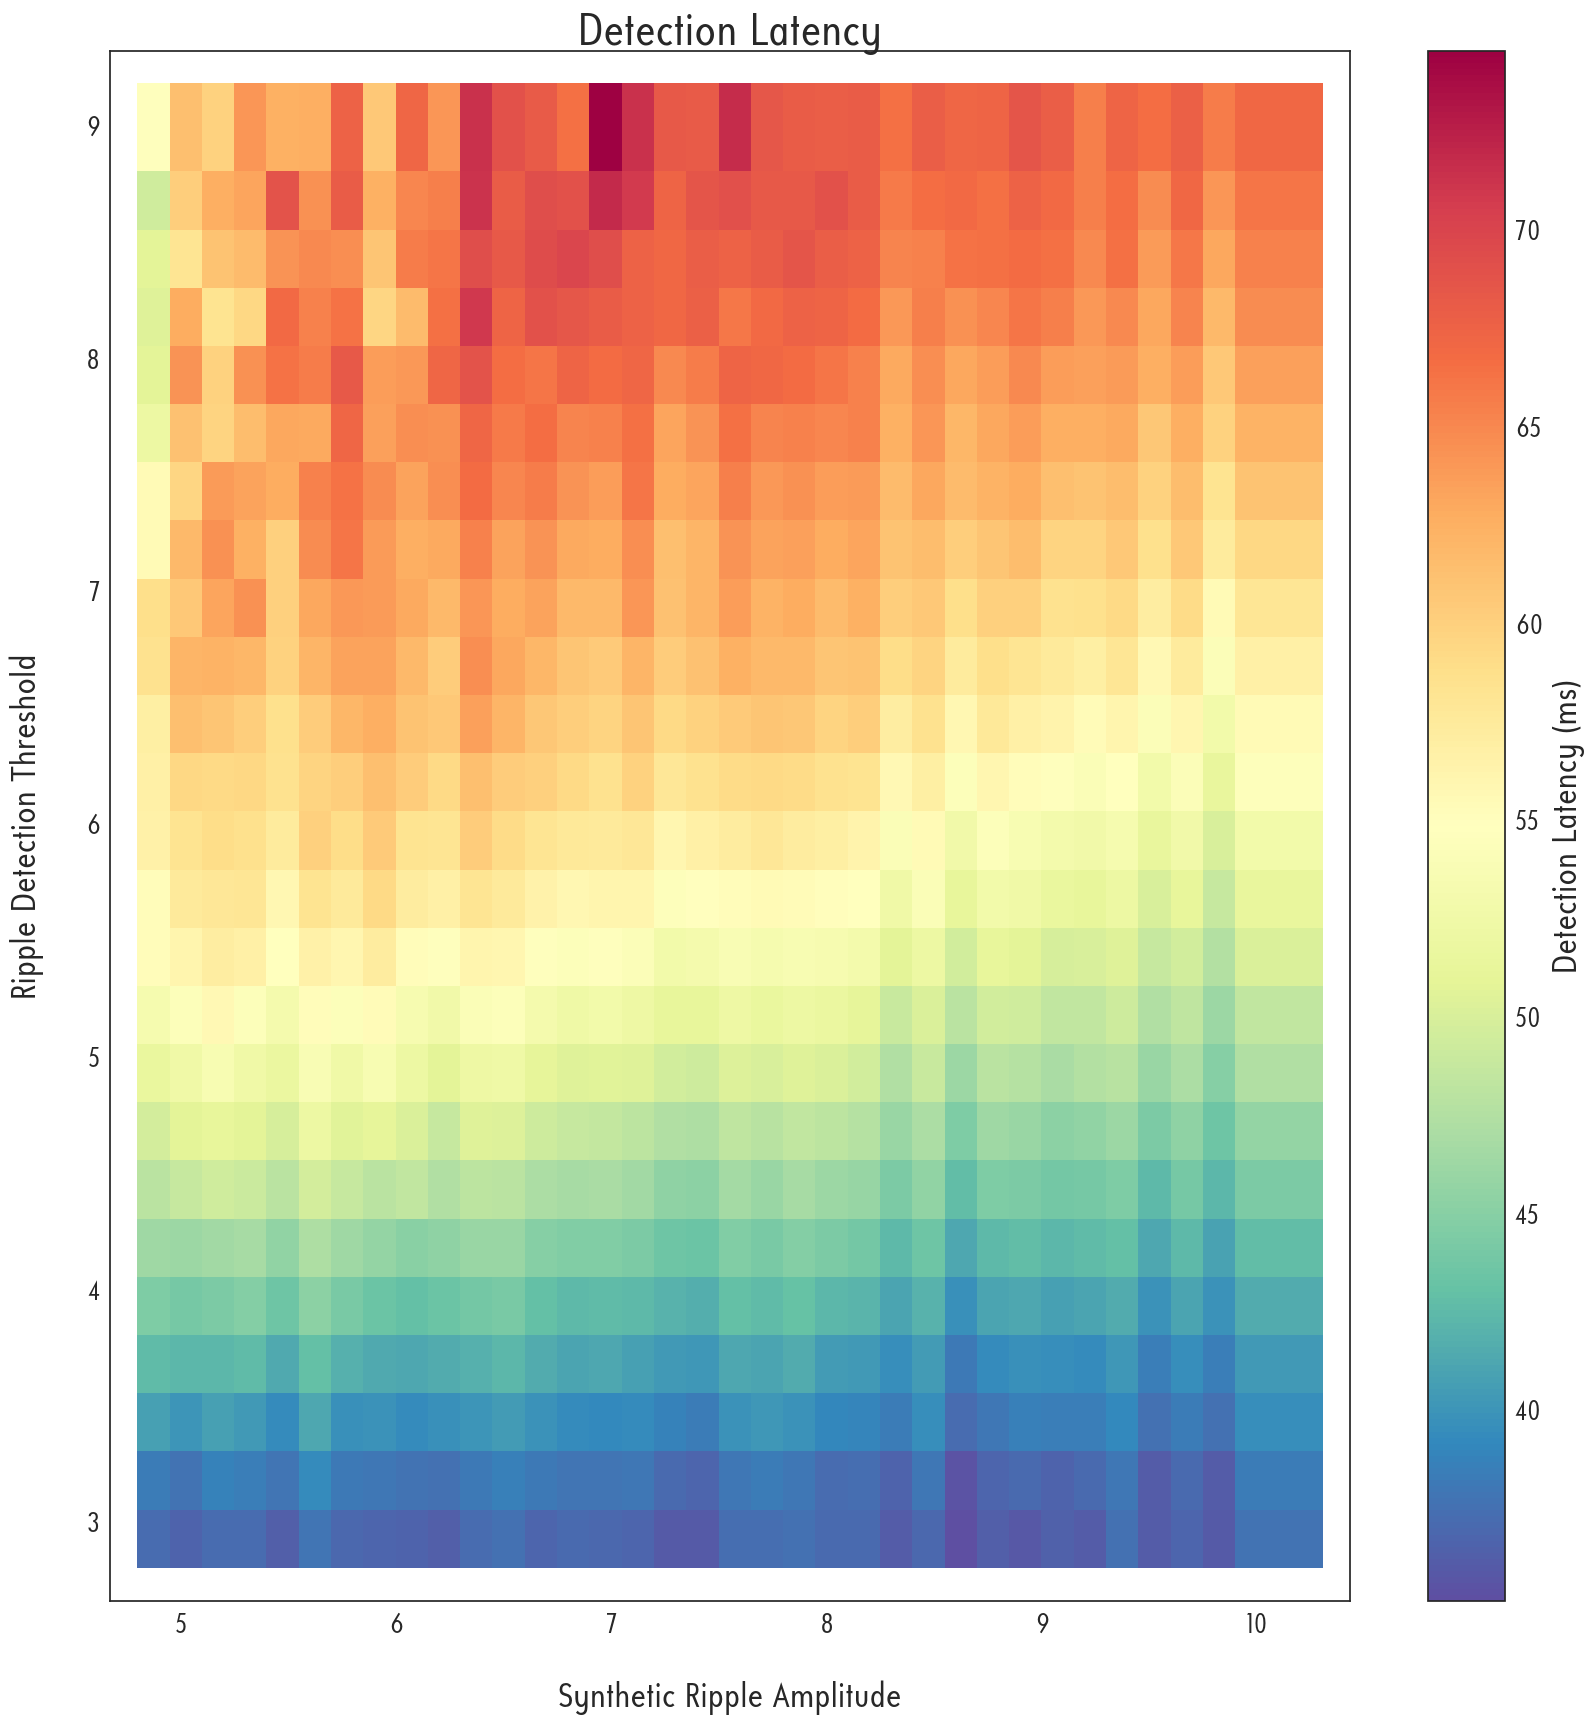

In [ ]:
fig = plt.figure()
ax = fig.gca()
plt.scatter(synthRipAmpl, ripDetectThresh, c=detectLat,cmap="Spectral_r",s=4000,marker='s',edgecolors='')
plt.colorbar(label="Detection Latency (ms)")
ax.set_xlabel("Synthetic Ripple Amplitude",labelpad=30)
ax.set_ylabel("Ripple Detection Threshold",labelpad=30)
ax.set_title("Detection Latency",)
ax.set_ylim(bottom=min(ripDetectThresh)-0.33,top=max(ripDetectThresh)+0.33)
ax.set_xlim(left=min(synthRipAmpl)-0.33,right=max(synthRipAmpl)+0.33)
plt.show()

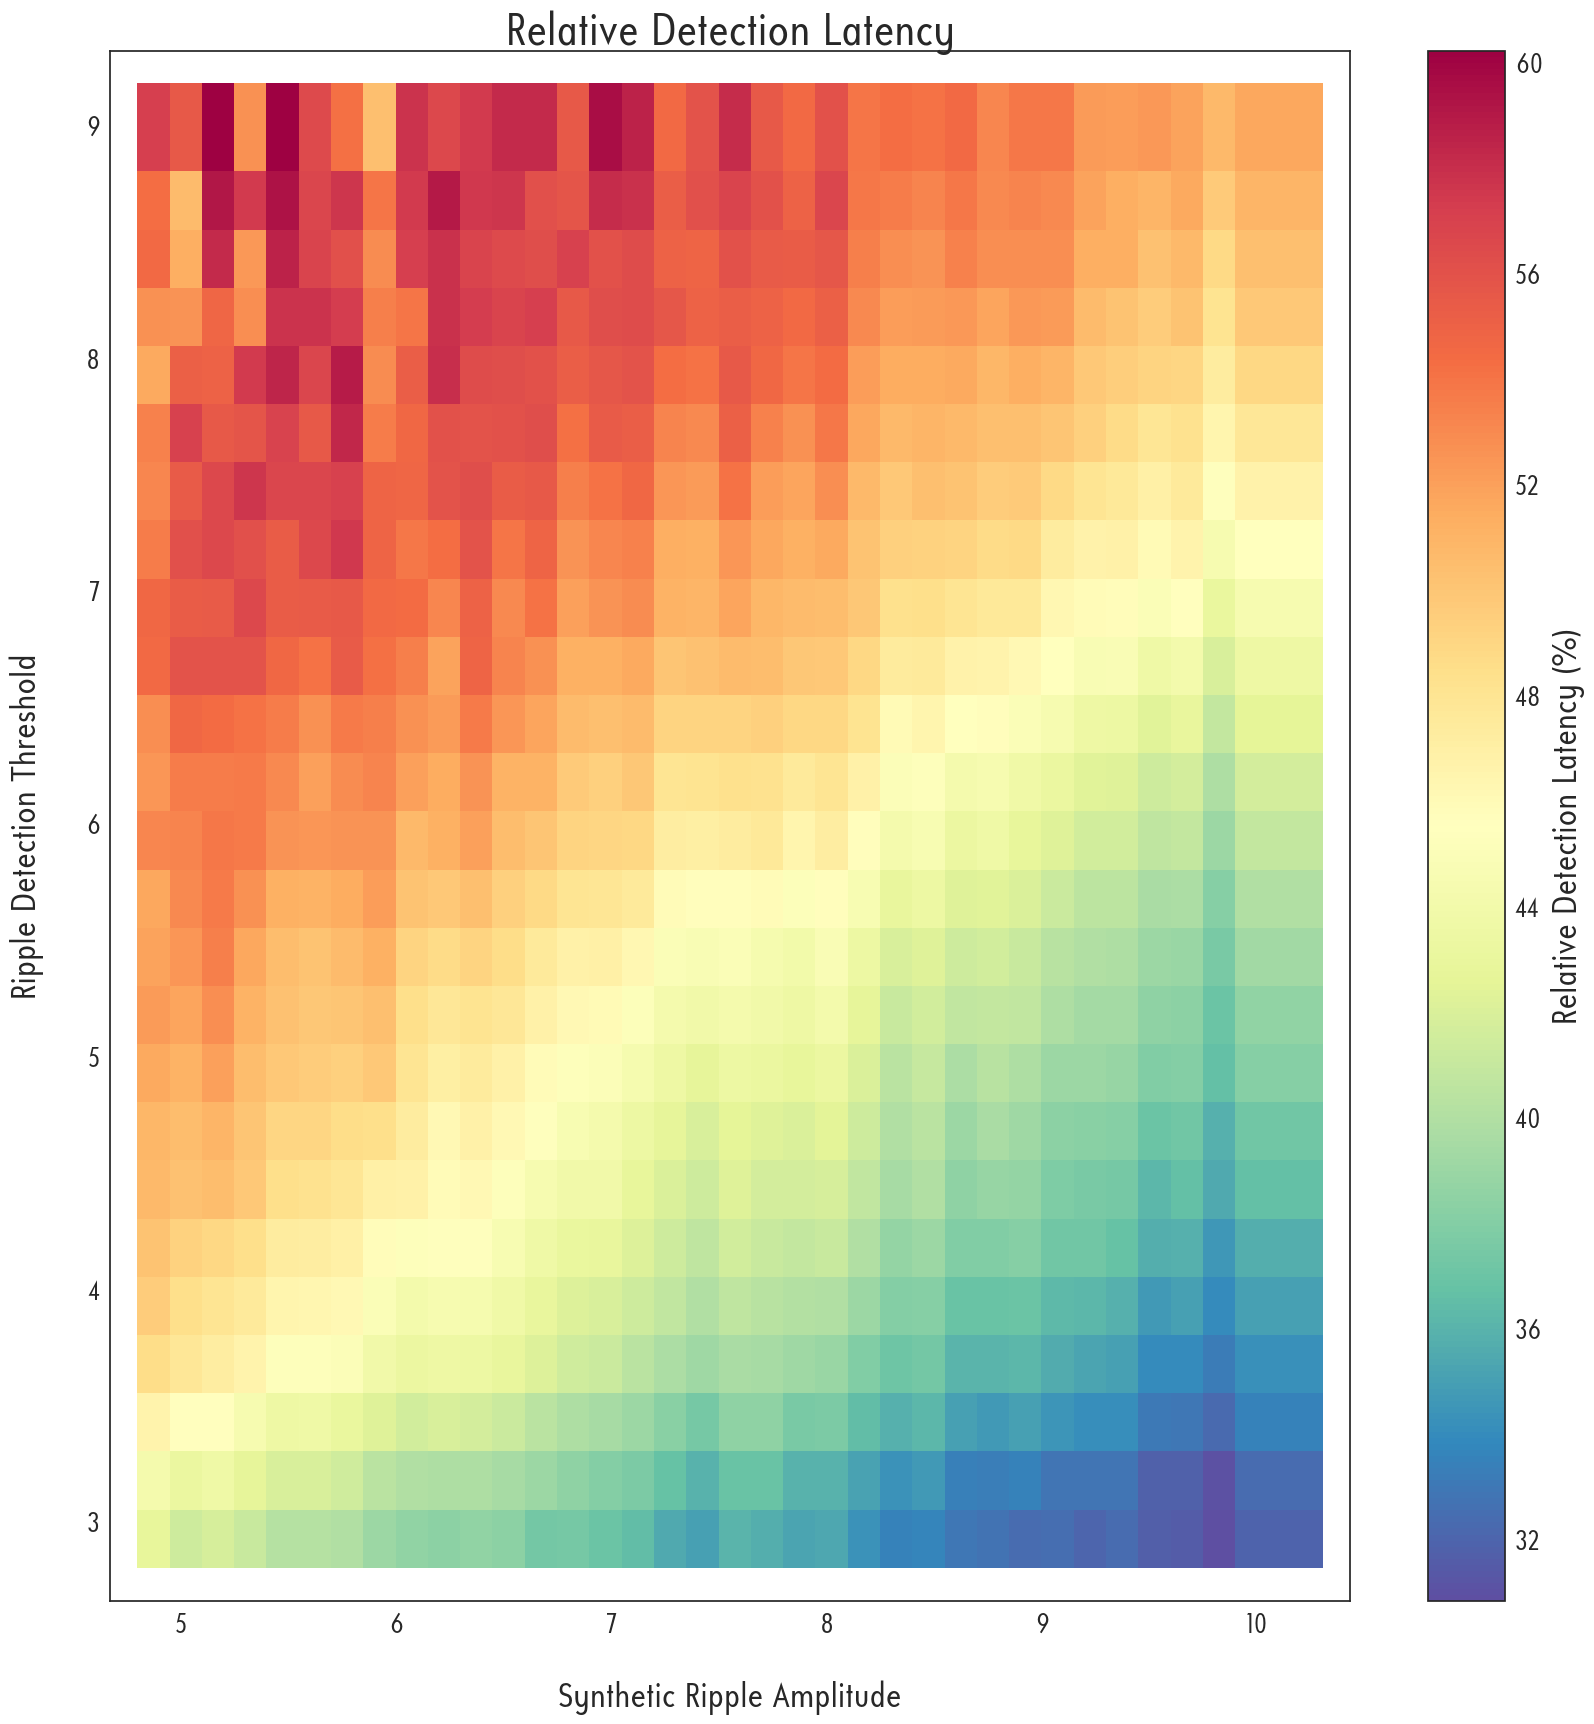

In [ ]:
fig = plt.figure()
ax = fig.gca()
plt.scatter(synthRipAmpl, ripDetectThresh, c=relDetectLat,cmap="Spectral_r",s=4000,marker='s',edgecolors='')
plt.colorbar(label="Relative Detection Latency (%)")
ax.set_xlabel("Synthetic Ripple Amplitude",labelpad=30)
ax.set_ylabel("Ripple Detection Threshold",labelpad=30)
ax.set_title("Relative Detection Latency",)
ax.set_ylim(bottom=min(ripDetectThresh)-0.33,top=max(ripDetectThresh)+0.33)
ax.set_xlim(left=min(synthRipAmpl)-0.33,right=max(synthRipAmpl)+0.33)
plt.show()

<div class="alert alert-info">
Notes:<br>
- ripple detection thresh 6 detects ground truth ripples at lower synthetic ripple amplitude because real-time filtering is different from offline filtering. <br>
- Both of these latency plots have some peaks and valleys...My explanation is the detection threshold is also changing since it's being filtered everytime the signal is being regenerated. UPDATE: Explanation checks out with some finagling
</div>

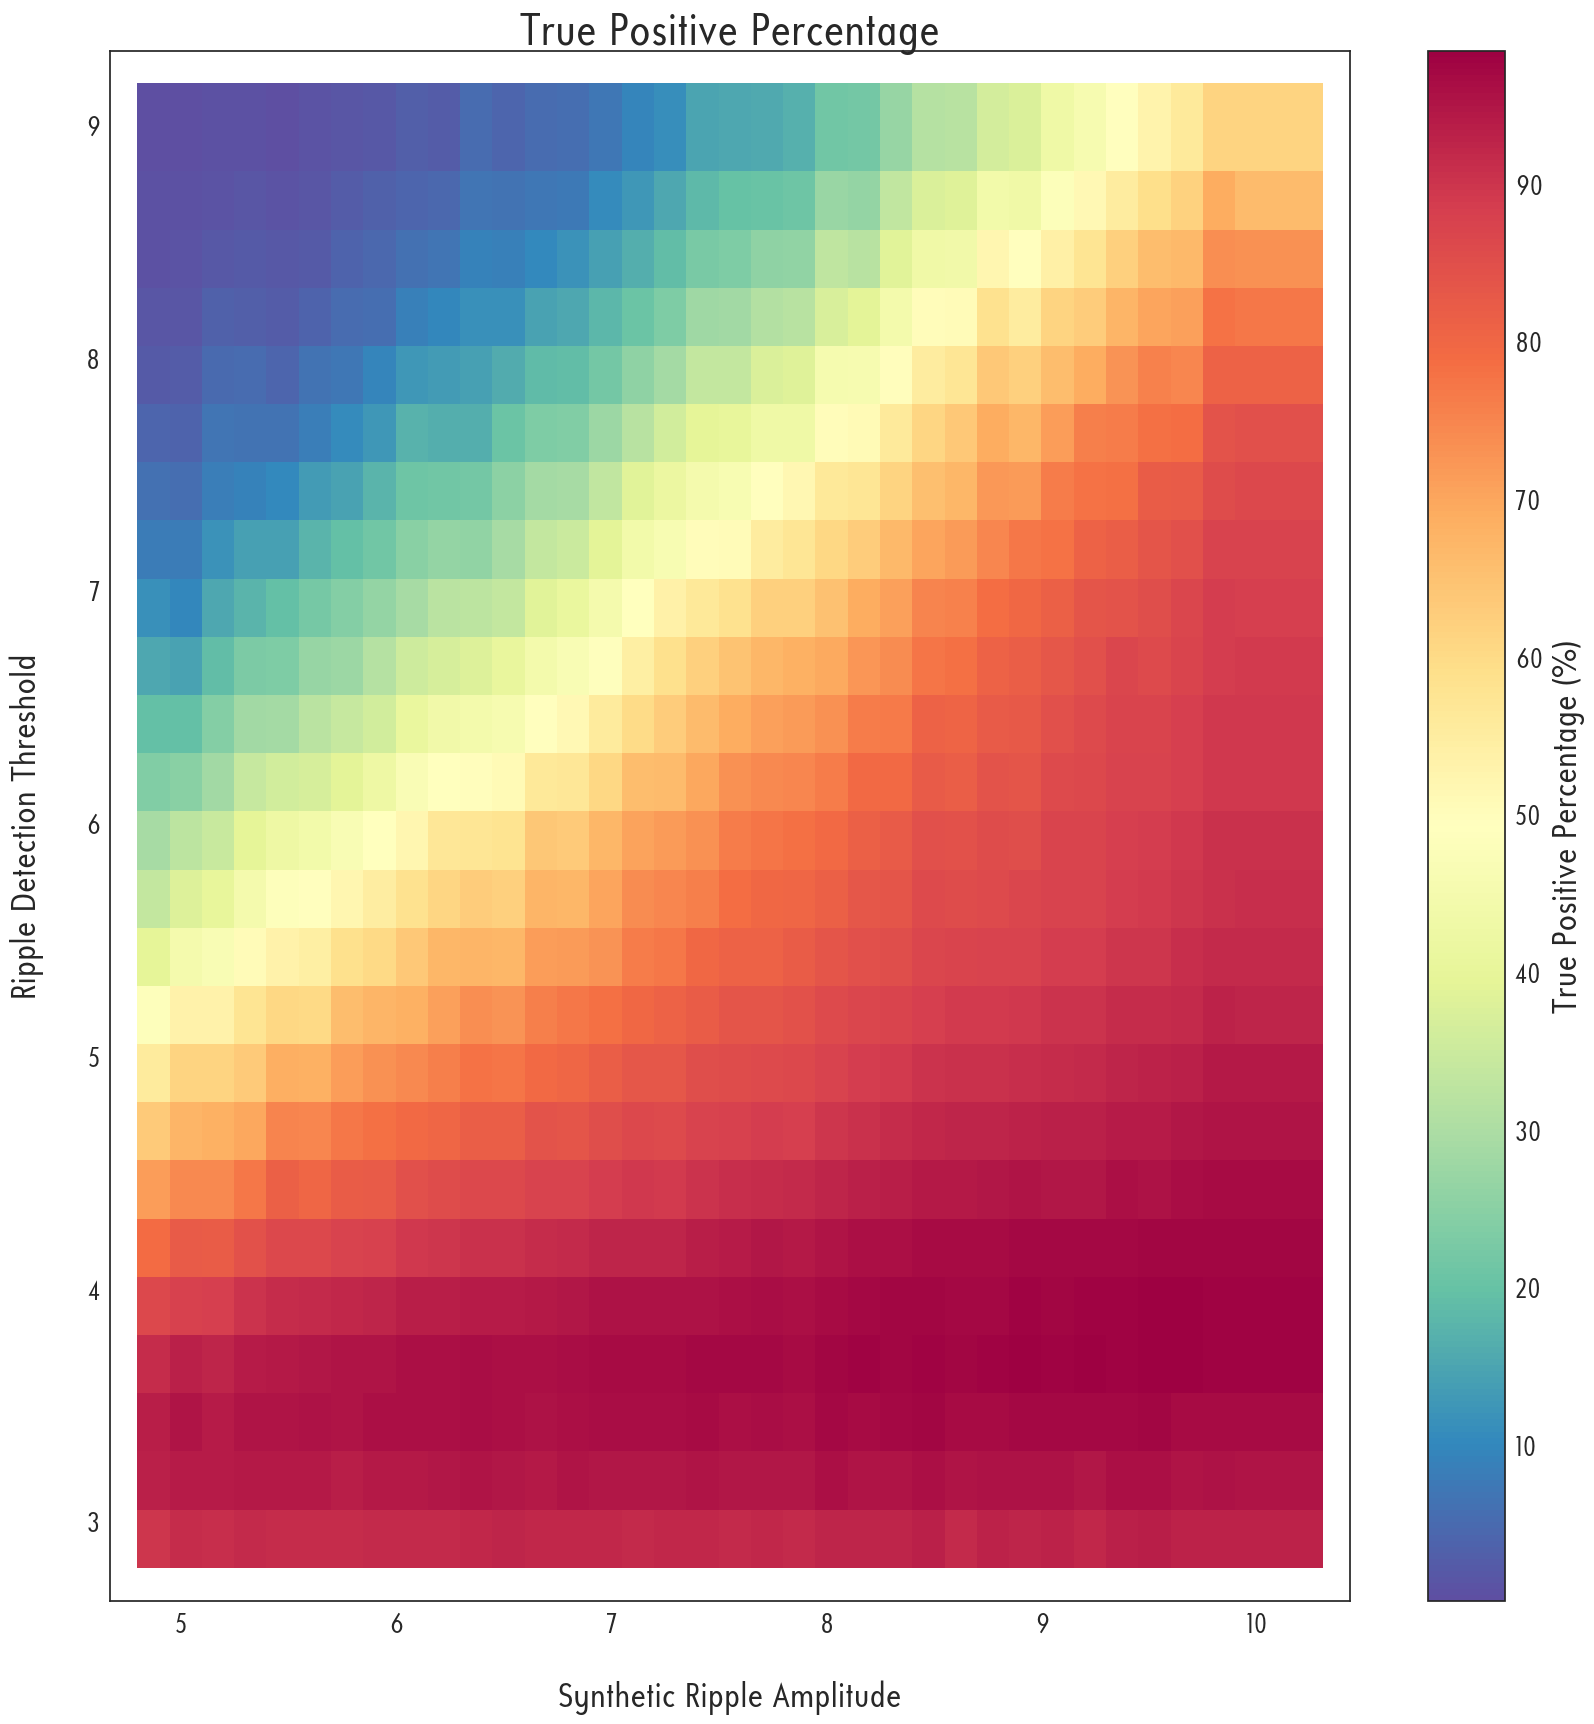

In [ ]:
fig = plt.figure()
ax = fig.gca()
plt.scatter(synthRipAmpl, ripDetectThresh, c=tpPercent,cmap="Spectral_r",s=4000,marker='s',edgecolors='')
plt.colorbar(label="True Positive Percentage (%)")
ax.set_xlabel("Synthetic Ripple Amplitude",labelpad=30)
ax.set_ylabel("Ripple Detection Threshold",labelpad=30)
ax.set_title("True Positive Percentage",)
ax.set_ylim(bottom=min(ripDetectThresh)-0.33,top=max(ripDetectThresh)+0.33)
ax.set_xlim(left=min(synthRipAmpl)-0.33,right=max(synthRipAmpl)+0.33)
plt.show()

<div class="alert alert-info">
Note(s): <br>
- This seems very intuitive higher threshold TP goes down...especially with low synthetic ripple peaks
</div>

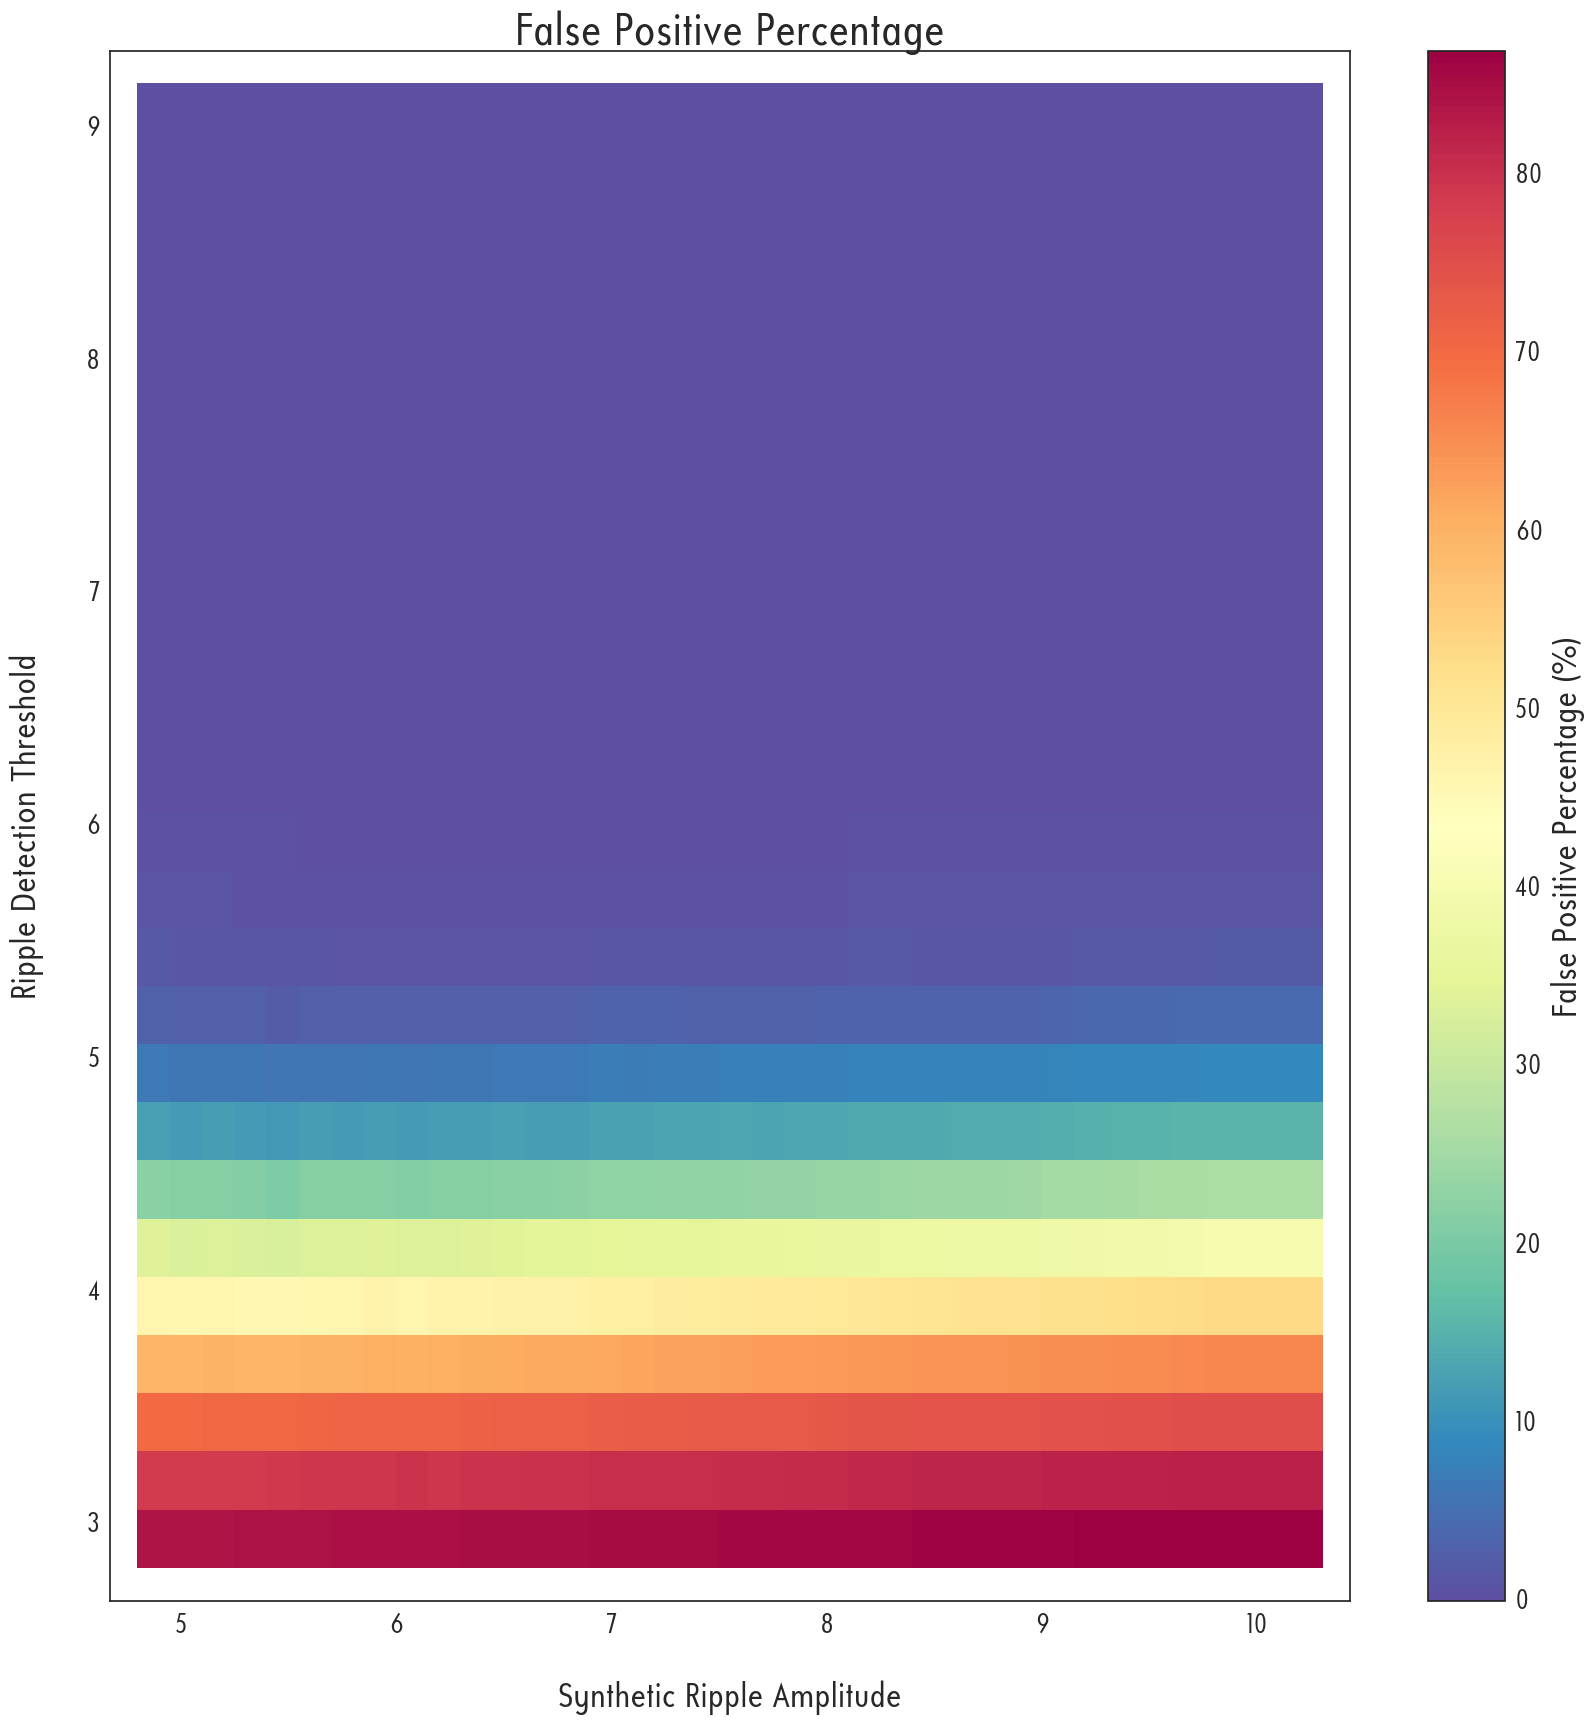

In [ ]:
fig = plt.figure()
ax = fig.gca()
plt.scatter(synthRipAmpl, ripDetectThresh, c=fpPercent,cmap="Spectral_r",s=4000,marker='s',edgecolors='')
plt.colorbar(label="False Positive Percentage (%)")
ax.set_xlabel("Synthetic Ripple Amplitude",labelpad=30)
ax.set_ylabel("Ripple Detection Threshold",labelpad=30)
ax.set_title("False Positive Percentage",)
ax.set_ylim(bottom=min(ripDetectThresh)-0.33,top=max(ripDetectThresh)+0.33)
ax.set_xlim(left=min(synthRipAmpl)-0.33,right=max(synthRipAmpl)+0.33)
plt.show()

<div class="alert alert-info">
Note(s): <br>
- Pretty intuitive results here...
</div>

## One more thing to check here is mean and standard deviation estimations _when_ there are ripples as opposed to just background noise
Obviously, if ripples are included in the mean and standard deviation estimation the threshold is going to be higher than it would be if we are only using the noise. In real data, we have to have ripples included in the parameter estimation. Well, we can technically take out defined ripple events but can't take out noise events easily. Actually, we can by setting a high threshold but I don't think it's worth it. I think it's computationally too taxing and might take up too much RAM depending on the size of the recording but this is very doable with `nelpy`. <br><br>
Anyways, since having ripples and noise within the data that you're going to use to estimate your threshold will result in higher mean and standard deviation parameter values, the z-scored threshold we're going to set in the real data will be lower than here in the synthetic. <b>Question we want to answer is: what exactly is a good threshold to set that we can test with _in vivo_? <br><br>
Easy answer is let's just do offline analysis of _in vivo_ data first</b>

## Just visualizing some data...this was more development steps...no need to check it out unless curious about me plotting random bits of data in which case knock yourself out but the fact that you are still reading this runon of a sentence with the word "run-on" spelled runon is interesting to me :)

(9.8, 10.5)

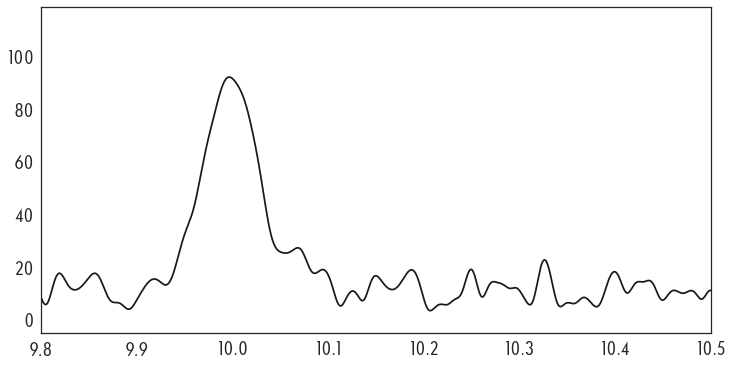

In [ ]:
ax = npl.plot(cow[0,2])
ax.set_xlim([9.8,10.5])

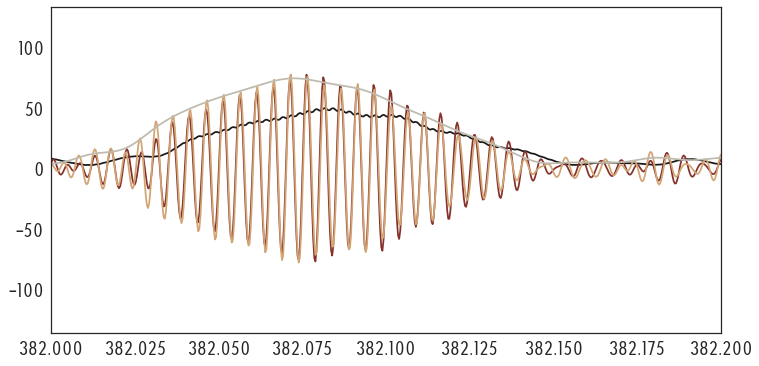

In [ ]:
plt.plot(cow.time,smoothed_envelope_simulated)
plt.plot(cow.time,rippleData_simulated)
npl.plot(cow[0,0],color=npl.colors.cows.jersey)
npl.plot(cow[0,2],color=npl.colors.cows.holstein)
plt.xlim((382,382.2))
plt.show()